In [121]:
#load packages 
import numpy as np
import pandas as pd
import scipy
import re
from PIL import Image
import glob
import os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from datetime import date
%matplotlib inline

In [122]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import utils
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [192]:
#grab file path names
image_paths = glob.glob("../data/movie-genre-from-its-poster/MoviePosters/*.jpg")
image_ids = []
for path in image_paths:
    start = path.rfind("/") +1
    end = len(path) - 4
    image_ids.append(path[start:end])

In [193]:
#sample image paths
image_path_sample = glob.glob("../data/movie-genre-from-its-poster/SampleMoviePosters/*.jpg")
image_ids_sample = []
for path in image_path_sample :
    start = path.rfind("/") +1
    end = len(path) - 4
    image_ids_sample.append(path[start:end])

In [194]:
df_movie = pd.read_csv("../data/movie-genre-from-its-poster/MovieGenre.csv", encoding = "ISO-8859-1")
df_imdb = pd.read_csv("../data/imdb.csv")

In [195]:
df_img_path = pd.DataFrame(image_paths)
df_img_path = df_img_path.rename(columns={0:'image_path'})
df_img_path['imdbId'] = image_ids

In [196]:
df_movie_sample = df_movie[df_movie["imdbId"].isin(image_ids_sample)]
df_movie_sample = df_movie_sample.drop_duplicates(subset=['imdbId'], keep="last")
target_sample = df_movie_sample['Genre']

In [197]:
titles = df_imdb['title'].to_list()

In [198]:
df_movie['imdbId'] = df_movie['imdbId'].astype(int)
df_img_path['imdbId'] = df_img_path['imdbId'].astype(int)

In [199]:
#too many garage movie poster limited it to well known movies
# and posters movies we have images for training
df_movie = pd.merge(df_movie, df_img_path, left_on='imdbId', right_on='imdbId')
df_movie = df_movie.drop_duplicates(subset=['imdbId'], keep="first")
df_movie = df_movie[df_movie["Title"].isin(titles)]



In [200]:
df_movie = df_movie.dropna()
image_paths = df_movie["image_path"].to_list()

In [201]:
df_movie.shape

(2685, 7)

In [202]:
df_movie["Genre"] = df_movie["Genre"].str.split("|")

In [203]:
y = df_movie["Genre"]

In [161]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
target_key = mlb.classes_

In [165]:
df_movie_temp = df_movie.join(pd.DataFrame(mlb.fit_transform(df_movie.pop('Genre')),
                          columns=mlb.classes_,
                          index=df_movie.index))

genre_col = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi',
       'Short', 'Sport', 'Thriller', 'War', 'Western']

In [166]:
df_movie_temp['genre_count'] = np.sum(y, axis=1)

In [167]:
y = y/(y !=0).sum(1).astype(float).reshape(2685,1)

In [168]:
#define the data generator 

batch_size = 500
img_height = 268
img_width = 182
def data_generator(image_paths, y, batch_size = batch_size):
    num_samples = len(image_paths)
    num_batches = num_samples // batch_size
    if num_samples % batch_size:
        num_batches += 1

    while 1:
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            if end_idx > num_samples:
                end_idx = num_samples
            image_paths_batch = image_paths[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]
            
            img_batch = np.array([img_to_array(
                    load_img(img, target_size=(img_height,img_width))
                    ) for img in image_paths_batch])
            
            
            img_batch = img_batch.astype('float32')/255.0
            
            yield img_batch, y_batch

In [169]:
#load sample images for testing
img_sample = np.array([img_to_array(
                    load_img(img, target_size=(img_height,img_width))
                    ) for img in image_path_sample[0:10]])
            
img_sample = img_sample.astype('float32')/255.0

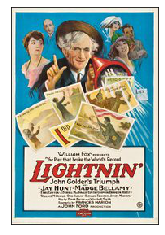

In [170]:
#check image are loading properly
plt.imshow(img_sample[1]);
plt.grid(True);
plt.xticks([]);
plt.yticks([]);

In [171]:
target_labels = target_key
total_classes = len(set(target_labels))
print("number of genre:", total_classes)

number of genre: 24


In [172]:
X_train_img, X_valid_img, y_train, y_valid = train_test_split(image_paths, y, 
                                                     random_state=42)

In [173]:
training_generator = data_generator(X_train_img, y_train)
validation_generator = data_generator(X_valid_img, y_valid)

steps_per_epoch = len(X_train_img) // batch_size
if len(X_train_img) % batch_size:
    steps_per_epoch += 1
    
validation_steps = len(X_valid_img) // batch_size
if len(X_valid_img) % batch_size:
    validation_steps += 1        

In [174]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_height, img_width, 3)))
model.add(Activation('relu')) # this is just different syntax for specifying the activation function
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [175]:
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(total_classes))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 266, 180, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 266, 180, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 133, 90, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 131, 88, 32)       9248      
_________________________________________________________________
activation_1 (Activation)    (None, 131, 88, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 65, 44, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 42, 64)        1

In [259]:
epochs = 50
history = model.fit_generator(
    generator=training_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=epochs) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 2 steps
Epoch 1/50
5/5 [==============================] - 47s 9s/step - loss: 0.2288 - accuracy: 0.8697 - val_loss: 0.1625 - val_accuracy: 0.8966
Epoch 2/50
5/5 [==============================] - 48s 10s/step - loss: 0.2222 - accuracy: 0.8742 - val_loss: 0.1585 - val_accuracy: 0.8966
Epoch 3/50
5/5 [==============================] - 47s 9s/step - loss: 0.2173 - accuracy: 0.8774 - val_loss: 0.1567 - val_accuracy: 0.8966
Epoch 4/50
5/5 [==============================] - 45s 9s/step - loss: 0.2092 - accuracy: 0.8775 - val_loss: 0.1559 - val_accuracy: 0.8966
Epoch 5/50
5/5 [==============================] - 46s 9s/step - loss: 0.2048 - accuracy: 0.8793 - val_loss: 0.1562 - val_accuracy: 0.8966
Epoch 6/50
5/5 [==============================] - 45s 9s/step - loss: 0.1996 - accuracy: 0.8812 - val_loss: 0.1553 - val_accuracy: 0.8966
Epoch 7/50
5/5 [==============================] - 46s 9s/step - loss: 0.2029 - ac

In [432]:
today = date.today()
model.save('../model/movie_poster_'+str(today))

INFO:tensorflow:Assets written to: ../model/movie_poster_2020-05-30/assets


In [204]:
def poster_classification(img, target_key=target_key, model=model):
    proba = model.predict(img)[0]
    idxs = np.argsort(proba)[::-1][:2]
    print("Poster Prediction")
    for (i, j) in enumerate(idxs):
        label = "{}: {:.2f}%".format(target_key[j], proba[j] * 100)
    for (label, p) in zip(target_key, proba):
        if p >= .05:
            print("{}: {:.2f}%".format(label, p * 100))
    print(df_movie.query('image_path == @img_path_find')['Genre'].to_list()[0])
            
    plt.imshow(img[0]);
    plt.grid(True);
    plt.xticks([]);
    plt.yticks([]);

In [429]:
#toystory 2 img_num 363
#sturt little 2 img_num 369
#do the right thing img_num 400
#requiem for a dream img_num 468

img_num = 485


img_test_predict = np.array([img_to_array(
                    load_img(image_paths[img_num], target_size=(img_height, img_width)))])
img_test_predict = img_test_predict.astype('float32')/255.0

img_path_find = image_paths[img_num]

Poster Prediction
Action: 10.02%
Adventure: 5.49%
Comedy: 23.85%
Drama: 33.37%
Romance: 5.07%
['Comedy', 'Drama', 'Romance']


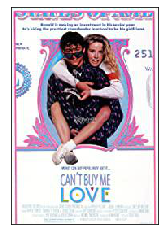

In [430]:
poster_classification(img_test_predict)

In [391]:
df_movie.query('image_path == @img_path_find')

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,image_path
3480,180093,http://www.imdb.com/title/tt180093,Requiem for a Dream (2000),8.4,[Drama],https://images-na.ssl-images-amazon.com/images...,../data/movie-genre-from-its-poster/MoviePoste...
